In [1]:
import operator
from typing import Any, Annotated

from langchain_community.document_loaders import WikipediaLoader
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch
from langgraph.errors import InvalidUpdateError
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from IPython.display import Image, display

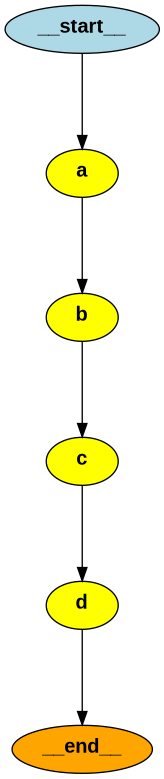

In [2]:
class State(TypedDict):
    state: str


class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}


builder = StateGraph(State)

builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("b", "c")
builder.add_edge("c", "d")
builder.add_edge("d", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_png()))


In [3]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm B"]
Adding I'm D to ["I'm C"]


{'state': ["I'm D"]}

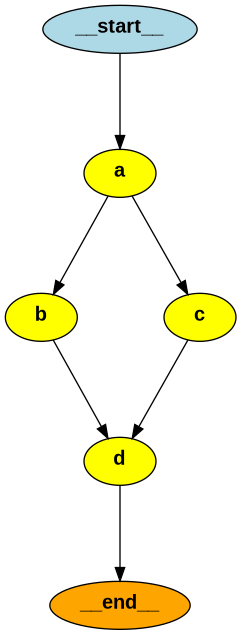

In [4]:
builder = StateGraph(State)

builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_png()))

In [5]:
try:
    graph.invoke({"state": []})
except InvalidUpdateError as e:
    print(f"An error occurred: {e}")

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
An error occurred: At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


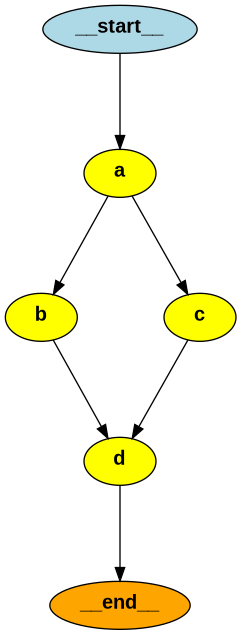

In [6]:
class State(TypedDict):
    state: Annotated[list, operator.add]


builder = StateGraph(State)

builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_png()))

In [7]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm D"]}

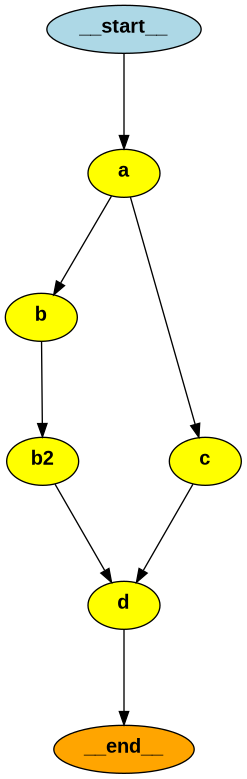

In [8]:
builder = StateGraph(State)

builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_png()))

In [9]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm C", "I'm B2"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm D"]}

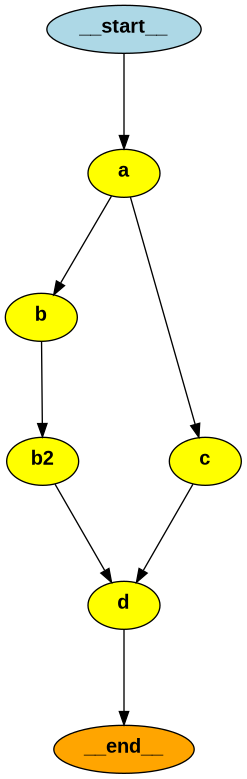

In [10]:
def sorting_reducer(left, right):
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right, list):
        right = [right]
    
    return sorted(left + right, reverse=False)


class State(TypedDict):
    state: Annotated[list, sorting_reducer]


builder = StateGraph(State)

builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_png()))

In [11]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm B2", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm B2", "I'm C", "I'm D"]}

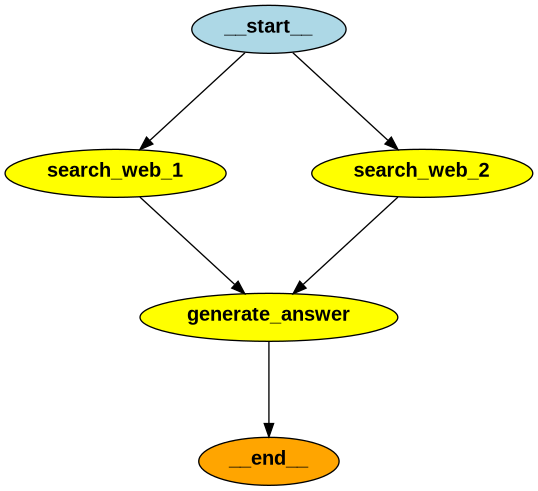

In [26]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)

class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]


def search_web(state):
    tavily_search = TavilySearch(max_results=3)
    search_docs = tavily_search.invoke(state['question'])

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs["results"]
        ]
    )
    return {"context": [formatted_search_docs]}


def search_wikipedia(state):
    search_docs = WikipediaLoader(query=state['question'], load_max_docs=2).load()

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}">\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"context": [formatted_search_docs]}


def generate_answer(state):
    context = state["context"]
    question = state["question"]

    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question, context=context)    
    answer = llm.invoke([SystemMessage(content=answer_instructions)] + [HumanMessage(content=f"Answer the question.")])
    return {"answer": answer}


builder = StateGraph(State)

builder.add_node("search_web_1",search_web)
builder.add_node("search_web_2", search_web)
builder.add_node("generate_answer", generate_answer)

builder.add_edge(START, "search_web_1")
builder.add_edge(START, "search_web_2")
builder.add_edge("search_web_1", "generate_answer")
builder.add_edge("search_web_2", "generate_answer")
builder.add_edge("generate_answer", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_png()))

In [27]:
result = graph.invoke({"question": "How were Nvidia's Q2 2024 earnings"})
result['answer'].content

"The provided context does not include specific financial results or performance metrics for Nvidia's Q2 2024 earnings. It primarily contains forward-looking statements and general information about Nvidia's products, technologies, and partnerships. For detailed earnings information, you would need to refer to Nvidia's official financial reports or credible financial news sources."